In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.2.0-bin-hadoop2.7')

from pyspark import conf, context, SparkConf, SparkContext
conf = SparkConf().setMaster('local').setAppName('socialNet')
sc = SparkContext(conf = conf)

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('socialNet').getOrCreate()

# Extract Data 

In [2]:
def parseLine(line):
    fields = line.split(',')
    age = int(fields[2])
    numFriends = int(fields[3])
    return (age, numFriends)

In [3]:
folder = '/home/ubuntu/data/raw/'
file = '/tamingBD-fakefriends.csv'

lines_rdd = sc.textFile(folder+file)
network_rdd = lines_rdd.map(parseLine)
    #Each line in lines_rdd is passed through parseLine 
    #and is parsed-out and mapped to new rdd

#output [(age, friends), (age, friends)...]
network_rdd.collect()[1:10]

[(26, 2),
 (55, 221),
 (40, 465),
 (68, 21),
 (59, 318),
 (37, 220),
 (54, 307),
 (38, 380),
 (27, 181)]

[33, 26, 55, 40, 68, 59, 37, 54, 38, 27] [385, 2, 221, 465, 21, 318, 220, 307, 380, 181]


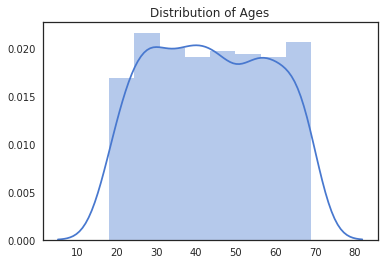

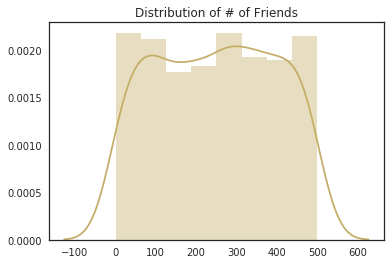

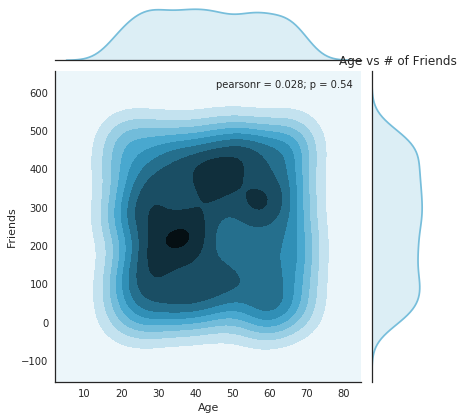

In [4]:
#Plot some stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)
import pandas as pd

ages_plt = []
friends_plt = []
for age, friends in network_rdd.collect():
    ages_plt.append(age)
    friends_plt.append(friends)
print(ages_plt[0:10] , friends_plt[0:10])
network_pd = pd.DataFrame(network_rdd.collect(), columns=['Age','Friends'])


sns.distplot(a=ages_plt, color='b');
plt.title('Distribution of Ages')
plt.show()
plt.clf()

sns.distplot(friends_plt, color='y');
plt.title('Distribution of # of Friends')
plt.show()
plt.clf()

sns.jointplot(x='Age', y='Friends', data=network_pd, kind = 'kde',color='c');
plt.title('Age vs # of Friends')
plt.show()
plt.clf()

# Agregate Information in RDD

In [5]:
#If you want to do these 2 steps in one line
#totalsByAge = network_rdd.mapValues(lambda x: (x, 1)).reduceByKey(lambda x, y: (x[0], x[1] + y[1]))

countsByAge = network_rdd.mapValues(lambda x: (x, 1))
countsByAge.collect()[0:20]
    #This is transforming our network_rdd to an rdd  with a 1 for counting

[(33, (385, 1)),
 (26, (2, 1)),
 (55, (221, 1)),
 (40, (465, 1)),
 (68, (21, 1)),
 (59, (318, 1)),
 (37, (220, 1)),
 (54, (307, 1)),
 (38, (380, 1)),
 (27, (181, 1)),
 (53, (191, 1)),
 (57, (372, 1)),
 (54, (253, 1)),
 (56, (444, 1)),
 (43, (49, 1)),
 (36, (49, 1)),
 (22, (323, 1)),
 (35, (13, 1)),
 (45, (455, 1)),
 (60, (246, 1))]

In [6]:
totalsByAge = countsByAge.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
totalsByAge.collect()[1:20]
    #This transformation counts up total number of friends for each age

[(19, (2346, 11)),
 (20, (825, 5)),
 (21, (2807, 8)),
 (22, (1445, 7)),
 (23, (2463, 10)),
 (24, (1169, 5)),
 (25, (2172, 11)),
 (26, (4115, 17)),
 (27, (1825, 8)),
 (28, (2091, 10)),
 (29, (2591, 12)),
 (30, (2594, 11)),
 (31, (2138, 8)),
 (32, (2287, 11)),
 (33, (3904, 12)),
 (34, (1473, 6)),
 (35, (1693, 8)),
 (36, (2466, 10)),
 (37, (2244, 9))]

In [7]:
meanByAge = totalsByAge.mapValues(lambda x: (x[0] / x[1]))
meanByAge.collect()[1:20]
    #This transformation counts up total number of friends for each age

[(19, 213.27272727272728),
 (20, 165.0),
 (21, 350.875),
 (22, 206.42857142857142),
 (23, 246.3),
 (24, 233.8),
 (25, 197.45454545454547),
 (26, 242.05882352941177),
 (27, 228.125),
 (28, 209.1),
 (29, 215.91666666666666),
 (30, 235.8181818181818),
 (31, 267.25),
 (32, 207.9090909090909),
 (33, 325.3333333333333),
 (34, 245.5),
 (35, 211.625),
 (36, 246.6),
 (37, 249.33333333333334)]

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27] [385, 2, 221, 465, 21, 318, 220, 307, 380, 181]


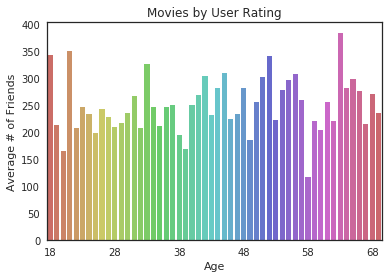

In [8]:
#Plot
plt.clf()
ages_plt = []
mean_plt = []
for age, mean in meanByAge.collect():
    ages_plt.append(age)
    mean_plt.append(mean)
print(ages_plt[0:10] , friends_plt[0:10])
network_pd = pd.DataFrame(network_rdd.collect(), columns=['Age','Mean'])

#https://seaborn.pydata.org/tutorial/color_palettes.html

g = sns.barplot(x=ages_plt, y=mean_plt, palette='hls')
plt.title('Movies by User Rating')
plt.xlabel('Age',)
plt.ylabel('Average # of Friends')
#plt.axis([1, 50, 0, 500,])
#plt.xlabel.set_ticks(np.arange(20,70,10))
#plt.locator_params(nbins=50)
#plt.locator_params(nbins=10, axis='x')

for ind, label in enumerate(g.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
#plt.axes()
plt.show()
plt.clf()